In [26]:
!pip install keras==2.3.1

You should consider upgrading via the 'c:\users\최동현\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [13]:
import random

from collections import deque

import numpy as np
import tensorflow as tf
import keras.backend as K

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

import pandas as pd
import math

Using TensorFlow backend.


In [27]:
#Data sample of BTC price
csv_test = pd.read_csv('C:/Users/최동현/Reinforcement/Bitcoin-Trading-Bot-main/BTC-Daily.csv')
csv_test.head()

,Timestamp,date,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
0,1417132800,2014-11-28 0:00,363.59,381.34,360.57,376.28,3220878.18,8617.15
1,1417219200,2014-11-29 0:00,376.42,386.60,372.25,376.72,2746157.05,7245.19
2,1417305600,2014-11-30 0:00,376.57,381.99,373.32,373.34,1145566.61,3046.33
3,1417392000,2014-12-01 0:00,376.40,382.31,373.03,378.39,2520662.37,6660.56
4,1417478400,2014-12-02 0:00,378.39,382.86,375.23,379.25,2593576.46,6832.53


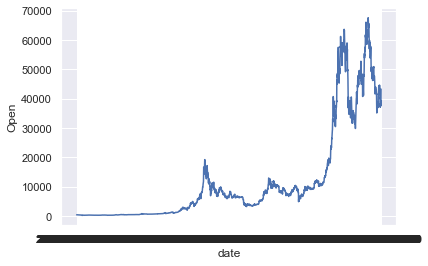

In [29]:
import seaborn as sns

sns.set(style='darkgrid')
ax = sns.lineplot(x='date', y='Open', data=csv_test)

In [14]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
    #Huber loss - Custom Loss Function for Q Learning
    error = y_true - y_pred
    cond = K.abs(error) <= clip_delta
    squared_loss = 0.5 * K.square(error)
    quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
    return K.mean(tf.where(cond, squared_loss, quadratic_loss))

In [15]:
def get_state(data, t, n_days): # here t is the current t and n is the window size
    d = t - n_days + 1 # if we have n previos day records they are stored else the first day record is assumed to be the record of the previous days
    if d >= 0:
      block = data[d: t + 1] 
    else:
      block = -d * [data[0]] + data[0: t + 1]
    #block is now the data for the last window_size days
    res = []
    for i in range(n_days - 1):
        res.append((block[i + 1] - block[i]))
     #res tells us the relation of the data from the last day
    return np.array([res]) #Returns an n-day state representation ending at time t

In [22]:
def train_model(agent, episode, data,init_xbt, ep_count=100, batch_size=32, window_size=10):
    total_profit = 0
    data_length = len(data) - 1 #number of entries
    format_position = lambda price: ('-$' if price < 0 else '+$') + '{0:.2f}'.format(abs(price))
    agent.inventory = []#empty inventory
    avg_loss = []

    state = get_state(data, 0, window_size + 1) # state is the vector with previos window size day records and their relation  we start with t = 0
    
    print('Episode {}/{}'.format(episode, ep_count))

    for t in range(data_length):# for loop for varying time stamp        
        reward = 0
        next_state = get_state(data, t + 1, window_size + 1)# get data for t+1 state

        action = agent.act(state) # class method to decide the action to take (buy,sell,sit )

        # BUY
        if action == 1:
            #print("Bought 1 XBT at price :{}".format(format_position(data[t])))
            init_xbt = init_xbt + 1  #We buy 1 unit of the coin
            agent.inventory.append(data[t])

        # SELL
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            init_xbt = init_xbt / 2 # We sell half the coins we have at time t
            delta = data[t] - bought_price
            reward = delta# positive reward if seling at time t price is higher than bought price 
            #print("Sold {} XBT at price :{}   || Profit : {}".format(init_xbt,format_position(data[t]),format_position(delta*init_xbt)))
            total_profit += delta*(init_xbt)  # keep a track of total profit

        # HOLD
        else:
            pass

        done = (t == data_length - 1)#only when we have traersed to all the days in the dataset
        agent.remember(state, action, reward, next_state, done)#store the datain memory

        if len(agent.memory) > batch_size:
            loss = agent.train_experience(batch_size) #train the model on the past experience
            avg_loss.append(loss) # track the loss in the the training

        state = next_state # now the current state will be the next state getState(data, t + 1, window_size + 1) i.e data for t+1 day

    agent.save(str(episode)+".h5") # save the model for each episode
    print("Total Profit : ",total_profit) #print total profit
    return (episode, ep_count, total_profit, np.mean(np.array(avg_loss)))

In [17]:
def evaluate_model(agent, data, window_size,init_xbt,init_amt):
    total_profit = 0
    data_length = len(data) - 1

    history = []
    agent.inventory = []
    format_position = lambda price: ('-$' if price < 0 else '+$') + '{0:.2f}'.format(abs(price))

    state = get_state(data, 0, window_size + 1)# state is the vector with previos window size day records and their relation  we start with t = 0

    for t in range(data_length):        
        reward = 0
        next_state = get_state(data, t + 1, window_size + 1)
        
        action = agent.act(state, is_eval=True)# select an action

        # BUY
        if action == 1 and init_amt > 0:
            print("Bought 1 XBT at price :{}".format(format_position(data[t])))
            init_xbt = init_xbt + 1 #We buy 1 bitcoin at that rate
            init_amt -= data[t] # anount deducted from balance
            agent.inventory.append(data[t])
            
            history.append((data[t], "BUY"))

        # SELL
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = min(agent.inventory)  # We sell the bitcoin first that we bought at the lowest price
            agent.inventory.pop(np.argmin(agent.inventory))
            init_xbt = init_xbt / 2 # Whenever we have to sell we sell half the coin we own at that moment
            delta = data[t] - bought_price
            reward = delta 
            print("Sold {} XBT at price :{}   || Profit : {}".format(init_xbt,format_position(data[t]),format_position(delta*init_xbt)))
            total_profit += delta*(init_xbt) # Track of total profit
            init_amt += data[t]*(init_xbt) # porfit amount is added in the account balance

            history.append((data[t], "SELL"))
        # HOLD
        else:
            print("Holding") 
            history.append((data[t], "HOLD"))

        done = (t == data_length - 1) # done true if traversed through all data
        agent.memory.append((state, action, reward, next_state, done)) # store this information in memory of the agent

        state = next_state 
        if done:
            return total_profit,init_amt,init_xbt,history

In [18]:
def show_eval_result(model_name, profit,amt,init_amt,xbt,init_xbt):
    format_position = lambda price: ('-$' if price < 0 else '+$') + '{0:.2f}'.format(abs(price))
    #print("\nSUMMARY:")
    #print('Initial Bank Balance: {}'.format(format_position(init_amt)))
    #print('Initial Bitcoins owned(1%): {}'.format(init_xbt))
    #print('\n')
    #print('Final Bank Balace: {}'.format(format_position(amt)))
    #print('Final Bitcoins owned: {}'.format(xbt))
    #print('\nTotal Profit: {}'.format(format_position(profit)))
    #print('(Trained Model  :{})'.format(model_name))
    return format_position(profit)

In [19]:
class Agent:

    def __init__(self, state_size, model_name=None):
      
        self.state_size = state_size    	# normalized previous days
        self.action_size = 3           		# [sit, buy, sell]
        self.model_name = model_name
        self.inventory = []
        self.memory = deque(maxlen=10000)

        self.model_name = model_name
        self.gamma = 0.95 # affinity for long term reward
        self.epsilon = 1.0  # for epsilon greedy algorithm
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.loss = huber_loss
        self.custom_objects = {"huber_loss": huber_loss}  # important for loading the model from memory
        self.optimizer = Adam(lr=self.learning_rate)

        if self.model_name is not None:
            self.model = self.load()
        else:
            self.model = self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=128, activation="relu", input_dim=self.state_size))
        model.add(Dense(units=256, activation="relu"))
        model.add(Dense(units=256, activation="relu"))
        model.add(Dense(units=128, activation="relu"))
        model.add(Dense(units=self.action_size))

        model.compile(loss=self.loss, optimizer=self.optimizer)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))# Add the data in memory of the agent

    def act(self, state, is_eval=False):
        if not is_eval and random.random() <= self.epsilon:#if we are training the model
            return random.randrange(self.action_size)# take random action in order to diversify experience at the beginning

        action_probs = self.model.predict(state)# if we are predicting we ask the model to predict the value of all possible actions
        #print("action_probs",action_probs)
        return np.argmax(action_probs[0])# we take the option with highest probabilty predicted by the model

    def train_experience(self, batch_size):#Train on previous experiences in memory
      
        mini_batch = random.sample(self.memory, batch_size)
        X_train, y_train = [], []
        target = 0

        for state, action, reward, next_state, done in mini_batch:
            if done:
                target = reward #reward of state action
            else:
              # approximate deep q-learning equation
              # Updating network weights using the Bellman Equation
              q_values = self.model.predict(state)# estimate q-values based on current state
              q_values[0][action] = target# update the target for current action based on discounted reward

              X_train.append(state[0])
              y_train.append(q_values[0])

 
        #parameters based on huber loss gradient
        loss = self.model.fit(
            np.array(X_train), np.array(y_train),
            epochs=1, verbose=0
        ).history["loss"][0]

        # as the training goes on we want the agent to make less random and more optimal decisions
        if self.epsilon > self.epsilon_min:#by this in each batch we reduce the epsilon value and when the model is trained few times we will  start predict action from model instead of an random no in method act 
            self.epsilon *= self.epsilon_decay

        return loss

    def save(self, episode):
        self.model.save("model{}".format(episode)) # save the trained model

    def load(self):
        return load_model(self.model_name, custom_objects=self.custom_objects) # load an existing trained model

In [20]:
def get_stock_data(stock_file):
    df = pd.read_csv(stock_file + '.csv')
    return list(df['Open']),df['Volume_(BTC)'][0] #Consider Opening price at each minute and initial bitcoint the agent will have
# We assume that the agent bys and sell the bitcoin on the opening price of the minute as sata is of 1 min interval

In [23]:
# For training of model
train_stock = input("Enter the name of stock file")

window_size = int(input("Enter window size")) # window size represents the number of previous days record model considers to take action

batch_size = 32
ep_count = int(input("Enter episode count"))# similar to epoch
model_name = ""


agent = Agent(window_size) #Create a object of the class Agent
train_data,init_xbt = get_stock_data(train_stock) #get vectorised format of csv data and initial bitcoin (1%)

for episode in range(1, ep_count + 1):  # in one  episode we traverse trough the data 1 time
  train_result = train_model(agent, episode, train_data,init_xbt, ep_count=ep_count,batch_size=batch_size, window_size=window_size)
  
#BTC-USD
#get_stock_data(train_stock)
#BTC-2021min

Enter the name of stock fileBTC-Daily
Enter window size10
Enter episode count1
Episode 1/1
Total Profit :  -4303397.204115803


In [72]:
# For evaluating model

eval_stock = 'BTC-USD'
model_name = ['model1','model2','model3','model4','model5','model6','model7','model8','model9','model10']
window_size = 10
data,init_xbt = get_stock_data(eval_stock)
init_xbt = init_xbt*0.01 # initial amount of coins (1%)
init_amt = 500000

l = []
for i in range(10):
    agent1 = Agent(window_size, model_name=model_name[i]) # create an object of the class agent
    profit,amt, xbt,_ = evaluate_model(agent1, data, window_size,init_xbt,init_amt) # predictiong from the model
    l.append(show_eval_result(model_name[i], profit,amt,init_amt,xbt,init_xbt)) # displaying summary

print(l)
#BTC-USD


Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding


Bought 1 XBT at price :+$7500.90
Holding
Holding
Holding
Bought 1 XBT at price :+$7632.52
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$6342.75
Sold 2.425719912257438 XBT at price :+$6674.08   || Profit : +$803.71
Holding
Sold 1.212859956128719 XBT at price :+$6545.53   || Profit : -$1158.73
Holding
Sold 0.6064299780643595 XBT at price :+$6742.39   || Profit : -$539.80
Holding
Holding
Holding
Holding
Sold 0.30321498903217975 XBT at price :+$6164.28   || Profit : -$472.48
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$6272.70
Holding
Sold 0.6516074945160899 XBT at price :+$6739.65   || Profit : +$304.27
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$7417.80
Holding
Holding
Holding
Holding
Sold 0.825803747258045 XBT at price :+$7950.40   || Profit : +$439.82
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$7

Holding
Holding
Holding
Bought 1 XBT at price :+$11322.57
Bought 1 XBT at price :+$11758.76
Holding
Sold 1.9349058824551473 XBT at price :+$11246.20   || Profit : +$3030.00
Holding
Holding
Holding
Bought 1 XBT at price :+$11604.55
Sold 1.4674529412275736 XBT at price :+$11737.33   || Profit : +$608.63
Holding
Holding
Sold 0.7337264706137868 XBT at price :+$11404.60   || Profit : -$146.71
Holding
Holding
Sold 0.3668632353068934 XBT at price :+$11768.70   || Profit : +$3.64
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$11366.89
Sold 0.6834316176534467 XBT at price :+$11485.61   || Profit : +$81.13
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$10797.76
Sold 0.8417158088267234 XBT at price :+$10973.25   || Profit : +$147.71
Holding
Bought 1 XBT at price :+$10933.75
Bought 1 XBT at price :+$11095.87
Hold

Holding
Holding
Sold 0.7343675741970587 XBT at price :+$1042.21   || Profit : +$51.52
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$1134.14
Sold 0.8671837870985293 XBT at price :+$1125.81   || Profit : -$7.22
Holding
Holding
Holding
Bought 1 XBT at price :+$1187.30
Holding
Holding
Sold 0.9335918935492646 XBT at price :+$1201.02   || Profit : +$12.81
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$1250.45
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$1321.87
Holding
Bought 1 XBT at price :+$1421.03
Holding
Holding
Holding
Holding
Sold 1.9667959467746323 XBT at price :+$1579.47   || Profit : +$647.12
Bought 1 XBT at price :+$1596.92
Holding
Holding
Holding
Bought 1 XBT at price :+$1845.76
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$2043.19
Holding
Bought 1 XBT at price :+$2321.37
Sold 2.983397973387316 XBT at price :+$2446.24   || Profit : +$

Bought 1 XBT at price :+$8515.49
Holding
Holding
Bought 1 XBT at price :+$8504.41
Holding
Bought 1 XBT at price :+$8091.83
Sold 7.756506632331674 XBT at price :+$8255.73   || Profit : +$8946.90
Holding
Holding
Sold 3.878253316165837 XBT at price :+$8419.87   || Profit : +$3736.54
Bought 1 XBT at price :+$8037.08
Holding
Bought 1 XBT at price :+$7592.30
Bought 1 XBT at price :+$7486.48
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$7500.70
Holding
Bought 1 XBT at price :+$7632.09
Bought 1 XBT at price :+$7722.53
Bought 1 XBT at price :+$7500.90
Holding
Holding
Sold 5.439126658082919 XBT at price :+$7685.14   || Profit : +$1080.54
Bought 1 XBT at price :+$7632.52
Bought 1 XBT at price :+$7499.55
Bought 1 XBT at price :+$6799.29
Sold 4.21956332904146 XBT at price :+$6905.82   || Profit : +$449.51
Bought 1 XBT at price :+$6596.88
Bought 1 XBT at price :+$6342.75
Holding
Bought 1 XBT at price :+$6455.45
Bought 1 XBT at price :+$6545.53
Holding
Sold 4.10978166452073 XBT at 

Sold 1.6360368924318385 XBT at price :+$10889.49   || Profit : +$5230.74
Sold 0.8180184462159192 XBT at price :+$10038.42   || Profit : +$1894.44
Sold 0.4090092231079596 XBT at price :+$10319.42   || Profit : +$1022.44
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$10764.57
Bought 1 XBT at price :+$10142.52
Holding
Bought 1 XBT at price :+$10407.64
Bought 1 XBT at price :+$10160.74
Holding
Sold 2.20450461155398 XBT at price :+$10372.83   || Profit : +$5491.71
Sold 1.10225230577699 XBT at price :+$10203.43   || Profit : +$2553.37
Holding
Holding
Bought 1 XBT at price :+$9597.54
Holding
Bought 1 XBT at price :+$9757.47
Holding
Bought 1 XBT at price :+$10621.18
Bought 1 XBT at price :+$10588.18
Holding
Holding
Bought 1 XBT at price :+$10518.11
Sold 3.0511261528884948 XBT at price :+$10443.23   || Profit : +$7608.15
Holding
Holding
Bought 1 XBT at price :+$10176.82
Holding
Sold 2.0255630764442474 XBT at price :+$10345.40   || Profit : +$4767.20
Holding
Holding
Sold 1.012781538222

Bought 1 XBT at price :+$11913.08
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$310.83
Bought 1 XBT at price :+$292.03
Bought 1 XBT at price :+$288.05
Bought 1 XBT at price :+$286.04
Bought 1 XBT at price :+$278.09
Bought 1 XBT at price :+$279.33
Bought 1 XBT at price :+$274.77
Sold 4.85392502 XBT at price :+$273.50   || Profit : -$6.15
Bought 1 XBT at price :+$278.88
Bought 1 XBT at price :+$275.66
Sold 3.42696251 XBT at price :+$277.34   || Profit : +$5.77
Bought 1 XBT at price :+$276.01
Sold 2.213481255 XBT at price :+$288.16   || Profit : +$26.91
Sold 1.1067406275 XBT at price :+$288.64   || Profit : +$11.68
Sold 0.55337031375 XBT at price :+$292.64   || Profit : +$7.61
Sold 0.276685156875 XBT at price :+$293.63   || Profit : +$3.96
Sold 0.1383425784375 XBT at price :+$294.48   || Profit : +$1.17
Sold 0.06917128921875 XBT at price :+$289.10   || Profit : +$0.07
Sold 0.034585644609375 XBT at price :+$287.70   || Profit : -$0.15
Sold 0.0172928223046875 XBT 

Sold 0.0005950971756763027 XBT at price :+$600.81   || Profit : -$0.03
Sold 0.00029754858783815133 XBT at price :+$608.02   || Profit : -$0.01
Sold 0.00014877429391907566 XBT at price :+$606.24   || Profit : -$0.01
Sold 7.438714695953783e-05 XBT at price :+$605.02   || Profit : -$0.00
Sold 3.7193573479768916e-05 XBT at price :+$605.72   || Profit : -$0.00
Sold 1.8596786739884458e-05 XBT at price :+$609.93   || Profit : -$0.00
Sold 9.298393369942229e-06 XBT at price :+$613.95   || Profit : -$0.00
Sold 4.6491966849711145e-06 XBT at price :+$610.97   || Profit : -$0.00
Sold 2.3245983424855573e-06 XBT at price :+$612.05   || Profit : -$0.00
Sold 1.1622991712427786e-06 XBT at price :+$610.22   || Profit : -$0.00
Sold 5.811495856213893e-07 XBT at price :+$612.47   || Profit : -$0.00
Sold 2.9057479281069466e-07 XBT at price :+$612.61   || Profit : -$0.00
Sold 1.4528739640534733e-07 XBT at price :+$617.34   || Profit : -$0.00
Sold 7.264369820267366e-08 XBT at price :+$619.17   || Profit : -$0.

Bought 1 XBT at price :+$1800.86
Sold 6.56203100073742 XBT at price :+$1808.44   || Profit : +$6995.74
Bought 1 XBT at price :+$1741.70
Holding
Sold 3.78101550036871 XBT at price :+$1818.70   || Profit : +$4061.11
Bought 1 XBT at price :+$1897.37
Bought 1 XBT at price :+$1984.24
Bought 1 XBT at price :+$2067.03
Bought 1 XBT at price :+$2043.19
Bought 1 XBT at price :+$2191.56
Sold 4.390507750184355 XBT at price :+$2321.37   || Profit : +$6904.57
Bought 1 XBT at price :+$2446.24
Bought 1 XBT at price :+$2320.89
Bought 1 XBT at price :+$2196.27
Bought 1 XBT at price :+$2054.08
Bought 1 XBT at price :+$2159.43
Bought 1 XBT at price :+$2255.36
Bought 1 XBT at price :+$2187.19
Bought 1 XBT at price :+$2288.33
Bought 1 XBT at price :+$2404.03
Bought 1 XBT at price :+$2493.72
Sold 7.1952538750921775 XBT at price :+$2547.79   || Profit : +$12922.37
Bought 1 XBT at price :+$2512.40
Bought 1 XBT at price :+$2690.84
Bought 1 XBT at price :+$2869.38
Bought 1 XBT at price :+$2720.49
Bought 1 XBT at

Bought 1 XBT at price :+$7500.90
Bought 1 XBT at price :+$7625.97
Bought 1 XBT at price :+$7650.82
Bought 1 XBT at price :+$7685.14
Bought 1 XBT at price :+$7632.52
Bought 1 XBT at price :+$7499.55
Bought 1 XBT at price :+$6799.29
Bought 1 XBT at price :+$6905.82
Bought 1 XBT at price :+$6596.88
Bought 1 XBT at price :+$6342.75
Bought 1 XBT at price :+$6674.08
Bought 1 XBT at price :+$6455.45
Bought 1 XBT at price :+$6545.53
Bought 1 XBT at price :+$6510.07
Bought 1 XBT at price :+$6742.39
Sold 26.50777569995087 XBT at price :+$6770.76   || Profit : +$155702.82
Bought 1 XBT at price :+$6780.09
Bought 1 XBT at price :+$6737.88
Bought 1 XBT at price :+$6090.10
Bought 1 XBT at price :+$6164.28
Bought 1 XBT at price :+$6171.97
Bought 1 XBT at price :+$6253.55
Bought 1 XBT at price :+$6084.40
Sold 16.753887849975435 XBT at price :+$6153.16   || Profit : +$88041.48
Bought 1 XBT at price :+$5898.13
Sold 8.876943924987717 XBT at price :+$6214.22   || Profit : +$47177.12
Bought 1 XBT at price :

Bought 1 XBT at price :+$11528.19
Bought 1 XBT at price :+$11385.05
Bought 1 XBT at price :+$10889.49
Bought 1 XBT at price :+$10038.42
Bought 1 XBT at price :+$10319.42
Bought 1 XBT at price :+$10358.72
Bought 1 XBT at price :+$10233.01
Bought 1 XBT at price :+$10350.28
Bought 1 XBT at price :+$10916.35
Bought 1 XBT at price :+$10764.57
Bought 1 XBT at price :+$10142.52
Bought 1 XBT at price :+$10136.31
Bought 1 XBT at price :+$10407.64
Bought 1 XBT at price :+$10160.74
Bought 1 XBT at price :+$10126.30
Bought 1 XBT at price :+$10372.83
Bought 1 XBT at price :+$10203.43
Bought 1 XBT at price :+$9756.79
Bought 1 XBT at price :+$9514.84
Bought 1 XBT at price :+$9597.54
Bought 1 XBT at price :+$9630.59
Bought 1 XBT at price :+$9757.47
Bought 1 XBT at price :+$10345.73
Sold 14.198906134584814 XBT at price :+$10621.18   || Profit : +$136629.88
Bought 1 XBT at price :+$10588.18
Bought 1 XBT at price :+$10578.20
Bought 1 XBT at price :+$10353.93
Bought 1 XBT at price :+$10518.11
Bought 1 XBT

Bought 1 XBT at price :+$6640.45
Bought 1 XBT at price :+$7116.55
Bought 1 XBT at price :+$7092.29
Bought 1 XBT at price :+$7260.92
Bought 1 XBT at price :+$7186.87
Bought 1 XBT at price :+$6879.78
Bought 1 XBT at price :+$6879.44
Bought 1 XBT at price :+$7121.31
Bought 1 XBT at price :+$7434.18
Bought 1 XBT at price :+$7550.48
Bought 1 XBT at price :+$7570.14
Bought 1 XBT at price :+$7679.42
Bought 1 XBT at price :+$7796.97
Bought 1 XBT at price :+$7806.71
Bought 1 XBT at price :+$8797.67
Bought 1 XBT at price :+$8672.78
Bought 1 XBT at price :+$8869.06
Bought 1 XBT at price :+$8983.61
Bought 1 XBT at price :+$8895.75
Bought 1 XBT at price :+$8912.83
Bought 1 XBT at price :+$9007.44
Bought 1 XBT at price :+$9261.90
Bought 1 XBT at price :+$9936.16
Bought 1 XBT at price :+$9840.91
Bought 1 XBT at price :+$9591.17
Sold 39.12993137356801 XBT at price :+$8755.54   || Profit : +$301902.88
Bought 1 XBT at price :+$8610.39
Bought 1 XBT at price :+$8805.39
Bought 1 XBT at price :+$9271.33
Bou

Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding


Sold 1.0231028219741516 XBT at price :+$6253.55   || Profit : +$167.23
Sold 0.5115514109870758 XBT at price :+$6084.40   || Profit : -$44.80
Sold 0.2557757054935379 XBT at price :+$6153.16   || Profit : -$837.14
Sold 0.12788785274676895 XBT at price :+$5898.13   || Profit : -$749.09
Holding
Bought 1 XBT at price :+$6411.68
Sold 0.5639439263733845 XBT at price :+$6380.38   || Profit : -$17.65
Holding
Holding
Holding
Sold 0.28197196318669226 XBT at price :+$6638.69   || Profit : -$1762.47
Holding
Holding
Sold 0.14098598159334613 XBT at price :+$6775.08   || Profit : -$985.80
Bought 1 XBT at price :+$6739.21
Bought 1 XBT at price :+$6330.77
Holding
Sold 1.070492990796673 XBT at price :+$6235.03   || Profit : -$102.49
Bought 1 XBT at price :+$6247.50
Bought 1 XBT at price :+$6272.70
Sold 1.5352464953983365 XBT at price :+$6357.01   || Profit : +$168.12
Sold 0.7676232476991682 XBT at price :+$6739.65   || Profit : +$358.44
Bought 1 XBT at price :+$7315.32
Sold 0.8838116238495841 XBT at pric

Sold 1.36966544447931 XBT at price :+$7973.80   || Profit : -$101.37
Holding
Bought 1 XBT at price :+$8225.12
Sold 1.1848327222396549 XBT at price :+$8243.40   || Profit : +$168.80
Holding
Holding
Sold 0.5924163611198274 XBT at price :+$7490.70   || Profit : -$435.08
Sold 0.2962081805599137 XBT at price :+$8667.58   || Profit : +$123.31
Holding
Sold 0.14810409027995686 XBT at price :+$9565.10   || Profit : +$187.41
Holding
Holding
Bought 1 XBT at price :+$9202.46
Holding
Sold 0.5740520451399784 XBT at price :+$9259.78   || Profit : +$32.91
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$9352.39
Holding
Holding
Bought 1 XBT at price :+$8812.49
Sold 1.2870260225699892 XBT at price :+$9056.92   || Profit : +$314.59
Sold 0.6435130112849946 XBT at price :+$8759.75   || Profit : -$381.37
Holding
Bought 1 XBT at price :+$8811.94
Sold 0.8217565056424974 XBT at price :+$8705.71   || Profit : -$87.29
Bought 1 XBT at price :+$8491.17
Holding
Holding
Holding
Bought 1 XBT at price :+$8203.

Holding
Holding
Bought 1 XBT at price :+$269.16
Bought 1 XBT at price :+$284.88
Bought 1 XBT at price :+$293.14
Bought 1 XBT at price :+$310.83
Bought 1 XBT at price :+$292.03
Holding
Bought 1 XBT at price :+$286.04
Bought 1 XBT at price :+$278.09
Bought 1 XBT at price :+$279.33
Bought 1 XBT at price :+$274.77
Bought 1 XBT at price :+$273.50
Holding
Bought 1 XBT at price :+$275.66
Bought 1 XBT at price :+$277.34
Holding
Bought 1 XBT at price :+$288.16
Bought 1 XBT at price :+$288.64
Bought 1 XBT at price :+$292.64
Holding
Bought 1 XBT at price :+$294.48
Bought 1 XBT at price :+$289.10
Holding
Bought 1 XBT at price :+$284.69
Sold 10.35392502 XBT at price :+$280.45   || Profit : +$116.93
Bought 1 XBT at price :+$282.81
Bought 1 XBT at price :+$281.23
Bought 1 XBT at price :+$284.85
Sold 6.67696251 XBT at price :+$281.91   || Profit : +$56.13
Bought 1 XBT at price :+$278.74
Holding
Bought 1 XBT at price :+$261.12
Bought 1 XBT at price :+$265.48
Bought 1 XBT at price :+$264.34
Bought 1 XBT

Bought 1 XBT at price :+$603.59
Sold 8.222255834794263 XBT at price :+$597.28   || Profit : +$2764.02
Holding
Bought 1 XBT at price :+$602.96
Bought 1 XBT at price :+$602.75
Bought 1 XBT at price :+$600.81
Sold 5.611127917397131 XBT at price :+$608.02   || Profit : +$1942.35
Bought 1 XBT at price :+$606.24
Bought 1 XBT at price :+$605.02
Sold 3.8055639586985657 XBT at price :+$605.72   || Profit : +$1305.19
Bought 1 XBT at price :+$609.93
Bought 1 XBT at price :+$613.95
Bought 1 XBT at price :+$610.97
Bought 1 XBT at price :+$612.05
Sold 3.9027819793492826 XBT at price :+$610.22   || Profit : +$1350.70
Bought 1 XBT at price :+$612.47
Bought 1 XBT at price :+$612.61
Bought 1 XBT at price :+$617.34
Bought 1 XBT at price :+$619.17
Sold 3.9513909896746413 XBT at price :+$616.82   || Profit : +$1392.79
Sold 1.9756954948373207 XBT at price :+$619.24   || Profit : +$698.92
Bought 1 XBT at price :+$640.87
Bought 1 XBT at price :+$636.03
Bought 1 XBT at price :+$637.01
Holding
Bought 1 XBT at p

Bought 1 XBT at price :+$4605.16
Bought 1 XBT at price :+$4229.81
Sold 48.60928006052671 XBT at price :+$4229.34   || Profit : +$192228.94
Bought 1 XBT at price :+$4122.47
Bought 1 XBT at price :+$4168.88
Bought 1 XBT at price :+$4131.98
Bought 1 XBT at price :+$3875.37
Bought 1 XBT at price :+$3166.30
Sold 26.804640030263354 XBT at price :+$3637.75   || Profit : +$90119.69
Bought 1 XBT at price :+$3606.28
Bought 1 XBT at price :+$3591.09
Bought 1 XBT at price :+$4073.79
Bought 1 XBT at price :+$3916.36
Bought 1 XBT at price :+$3901.47
Bought 1 XBT at price :+$3628.02
Bought 1 XBT at price :+$3629.92
Bought 1 XBT at price :+$3796.15
Bought 1 XBT at price :+$3681.58
Bought 1 XBT at price :+$3928.41
Bought 1 XBT at price :+$3892.94
Bought 1 XBT at price :+$4197.13
Bought 1 XBT at price :+$4171.62
Bought 1 XBT at price :+$4166.11
Holding
Bought 1 XBT at price :+$4395.81
Bought 1 XBT at price :+$4408.46
Holding
Bought 1 XBT at price :+$4229.88
Bought 1 XBT at price :+$4324.46
Bought 1 XBT 

Holding
Bought 1 XBT at price :+$3746.71
Bought 1 XBT at price :+$3849.22
Bought 1 XBT at price :+$3931.05
Holding
Bought 1 XBT at price :+$3851.97
Bought 1 XBT at price :+$3836.52
Bought 1 XBT at price :+$4078.58
Bought 1 XBT at price :+$4028.47
Bought 1 XBT at price :+$4031.55
Holding
Bought 1 XBT at price :+$3674.02
Bought 1 XBT at price :+$3686.97
Bought 1 XBT at price :+$3658.87
Bought 1 XBT at price :+$3557.31
Bought 1 XBT at price :+$3704.22
Bought 1 XBT at price :+$3631.51
Bought 1 XBT at price :+$3651.87
Holding
Bought 1 XBT at price :+$3652.38
Bought 1 XBT at price :+$3725.45
Bought 1 XBT at price :+$3600.37
Bought 1 XBT at price :+$3575.08
Bought 1 XBT at price :+$3605.56
Bought 1 XBT at price :+$3584.50
Bought 1 XBT at price :+$3607.39
Bought 1 XBT at price :+$3599.72
Bought 1 XBT at price :+$3604.69
Holding
Bought 1 XBT at price :+$3468.87
Bought 1 XBT at price :+$3443.90
Bought 1 XBT at price :+$3485.41
Bought 1 XBT at price :+$3460.55
Bought 1 XBT at price :+$3484.63
Bou

Bought 1 XBT at price :+$9863.89
Bought 1 XBT at price :+$10115.56
Bought 1 XBT at price :+$9855.89
Bought 1 XBT at price :+$10202.39
Bought 1 XBT at price :+$10323.96
Bought 1 XBT at price :+$10211.55
Bought 1 XBT at price :+$10313.86
Bought 1 XBT at price :+$9889.18
Bought 1 XBT at price :+$9936.56
Bought 1 XBT at price :+$9691.23
Bought 1 XBT at price :+$10143.80
Bought 1 XBT at price :+$9629.33
Bought 1 XBT at price :+$9611.78
Bought 1 XBT at price :+$9687.71
Bought 1 XBT at price :+$9663.32
Bought 1 XBT at price :+$9921.58
Bought 1 XBT at price :+$9651.31
Bought 1 XBT at price :+$9338.29
Bought 1 XBT at price :+$8825.09
Bought 1 XBT at price :+$8788.73
Bought 1 XBT at price :+$8671.21
Bought 1 XBT at price :+$8599.76
Bought 1 XBT at price :+$8563.26
Bought 1 XBT at price :+$8865.39
Bought 1 XBT at price :+$8788.54
Bought 1 XBT at price :+$8760.29
Bought 1 XBT at price :+$9078.31
Bought 1 XBT at price :+$9121.60
Bought 1 XBT at price :+$8908.21
Bought 1 XBT at price :+$8111.15
Boug

Bought 1 XBT at price :+$430.01
Bought 1 XBT at price :+$457.54
Bought 1 XBT at price :+$453.38
Bought 1 XBT at price :+$448.24
Holding
Bought 1 XBT at price :+$448.18
Bought 1 XBT at price :+$434.67
Holding
Bought 1 XBT at price :+$430.26
Bought 1 XBT at price :+$365.07
Bought 1 XBT at price :+$387.15
Bought 1 XBT at price :+$381.73
Bought 1 XBT at price :+$387.03
Bought 1 XBT at price :+$379.74
Bought 1 XBT at price :+$419.63
Bought 1 XBT at price :+$409.75
Bought 1 XBT at price :+$382.43
Bought 1 XBT at price :+$388.10
Bought 1 XBT at price :+$402.32
Bought 1 XBT at price :+$392.00
Bought 1 XBT at price :+$392.44
Bought 1 XBT at price :+$395.15
Bought 1 XBT at price :+$380.11
Bought 1 XBT at price :+$378.86
Bought 1 XBT at price :+$378.29
Bought 1 XBT at price :+$369.35
Bought 1 XBT at price :+$372.92
Bought 1 XBT at price :+$374.65
Bought 1 XBT at price :+$370.17
Bought 1 XBT at price :+$388.90
Bought 1 XBT at price :+$386.59
Bought 1 XBT at price :+$376.51
Bought 1 XBT at price :+

Bought 1 XBT at price :+$791.01
Bought 1 XBT at price :+$790.69
Bought 1 XBT at price :+$792.25
Bought 1 XBT at price :+$800.64
Bought 1 XBT at price :+$834.18
Bought 1 XBT at price :+$864.89
Bought 1 XBT at price :+$922.18
Bought 1 XBT at price :+$899.65
Bought 1 XBT at price :+$896.91
Bought 1 XBT at price :+$908.35
Bought 1 XBT at price :+$934.83
Bought 1 XBT at price :+$975.12
Bought 1 XBT at price :+$972.53
Bought 1 XBT at price :+$960.63
Bought 1 XBT at price :+$963.66
Bought 1 XBT at price :+$998.62
Bought 1 XBT at price :+$1021.60
Bought 1 XBT at price :+$1044.40
Bought 1 XBT at price :+$1156.73
Bought 1 XBT at price :+$1014.24
Bought 1 XBT at price :+$903.49
Bought 1 XBT at price :+$908.17
Bought 1 XBT at price :+$913.24
Bought 1 XBT at price :+$902.44
Bought 1 XBT at price :+$908.11
Bought 1 XBT at price :+$775.18
Bought 1 XBT at price :+$803.74
Bought 1 XBT at price :+$825.14
Bought 1 XBT at price :+$818.14
Bought 1 XBT at price :+$821.78
Bought 1 XBT at price :+$830.95
Boug

Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Sold 339.35392502 XBT at price :+$8181.20   || Profit : +$2705035.00
Bought 1 XBT at price :+$7769.04
Bought 1 XBT at price :+$7634.19
Bought 1 XBT at price :+$7562.14
Bought 1 XBT at price :+$7438.67
Bought 1 XBT at price :+$7031.08
Bought 1 XBT at price :+$7062.94
Bought 1 XBT at price :+$6958.32
Bought 1 XBT at price :+$6746.85
Bought 1 XBT at price :+$6305.56
Bought 1 XBT at price :+$6571.42
Bought 1 XBT at price :+$6185.79
Bought 1 XBT at 

Bought 1 XBT at price :+$8229.84
Bought 1 XBT at price :+$8585.28
Bought 1 XBT at price :+$8585.26
Bought 1 XBT at price :+$8315.67
Bought 1 XBT at price :+$8336.90
Bought 1 XBT at price :+$8320.83
Bought 1 XBT at price :+$8373.46
Bought 1 XBT at price :+$8204.67
Bought 1 XBT at price :+$8047.81
Bought 1 XBT at price :+$8100.93
Bought 1 XBT at price :+$7973.80
Bought 1 XBT at price :+$7997.81
Bought 1 XBT at price :+$8225.12
Bought 1 XBT at price :+$8243.40
Bought 1 XBT at price :+$8076.23
Bought 1 XBT at price :+$7509.73
Bought 1 XBT at price :+$7490.70
Bought 1 XBT at price :+$8667.58
Bought 1 XBT at price :+$9241.71
Bought 1 XBT at price :+$9565.10
Bought 1 XBT at price :+$9248.44
Bought 1 XBT at price :+$9422.46
Bought 1 XBT at price :+$9202.46
Bought 1 XBT at price :+$9193.99
Bought 1 XBT at price :+$9259.78
Bought 1 XBT at price :+$9324.79
Bought 1 XBT at price :+$9235.61
Bought 1 XBT at price :+$9413.00
Bought 1 XBT at price :+$9340.86
Bought 1 XBT at price :+$9352.39
Bought 1 X

Bought 1 XBT at price :+$9126.09
Bought 1 XBT at price :+$9072.85
Bought 1 XBT at price :+$9349.16
Bought 1 XBT at price :+$9253.02
Bought 1 XBT at price :+$9427.99
Bought 1 XBT at price :+$9273.36
Bought 1 XBT at price :+$9277.51
Bought 1 XBT at price :+$9241.05
Bought 1 XBT at price :+$9277.21
Bought 1 XBT at price :+$9238.70
Bought 1 XBT at price :+$9241.90
Bought 1 XBT at price :+$9191.98
Bought 1 XBT at price :+$9131.81
Bought 1 XBT at price :+$9151.18
Bought 1 XBT at price :+$9158.01
Bought 1 XBT at price :+$9187.22
Bought 1 XBT at price :+$9162.51
Bought 1 XBT at price :+$9375.08
Bought 1 XBT at price :+$9527.14
Bought 1 XBT at price :+$9585.51
Bought 1 XBT at price :+$9539.49
Bought 1 XBT at price :+$9680.23
Bought 1 XBT at price :+$9905.22
Bought 1 XBT at price :+$11017.46
Bought 1 XBT at price :+$10912.95
Bought 1 XBT at price :+$11099.83
Bought 1 XBT at price :+$11110.21
Bought 1 XBT at price :+$11322.57
Bought 1 XBT at price :+$11758.76
Bought 1 XBT at price :+$11043.77
Bou

Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding


Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Bought 1 XBT at price :+$270.83
Bought 1 XBT at price :+$269.16
Bought 1 XBT at price :+$284.88
Bought 1 XBT at price :+$293.14
Bought 1 XBT at price :+$310.83
Bought 1 XBT at price :+$292.03
Bought 1 XBT at price :+$288.05
Bought 1 XBT at price :+$286.04
Bought 1 XBT at price :+$278.09
Bought 1 XBT at price :+$279.33
Bought 1 XBT at price :+$274.77
Bought 1 XBT at 

Bought 1 XBT at price :+$701.34
Bought 1 XBT at price :+$730.07
Bought 1 XBT at price :+$742.35
Bought 1 XBT at price :+$689.12
Bought 1 XBT at price :+$703.53
Bought 1 XBT at price :+$703.81
Bought 1 XBT at price :+$710.74
Bought 1 XBT at price :+$703.09
Bought 1 XBT at price :+$709.83
Bought 1 XBT at price :+$722.84
Bought 1 XBT at price :+$715.55
Bought 1 XBT at price :+$716.75
Bought 1 XBT at price :+$705.20
Bought 1 XBT at price :+$702.00
Bought 1 XBT at price :+$705.79
Bought 1 XBT at price :+$711.17
Bought 1 XBT at price :+$744.88
Bought 1 XBT at price :+$740.71
Bought 1 XBT at price :+$751.83
Bought 1 XBT at price :+$751.88
Bought 1 XBT at price :+$731.27
Bought 1 XBT at price :+$739.64
Bought 1 XBT at price :+$751.74
Bought 1 XBT at price :+$744.62
Bought 1 XBT at price :+$740.44
Bought 1 XBT at price :+$741.51
Bought 1 XBT at price :+$735.44
Bought 1 XBT at price :+$732.48
Bought 1 XBT at price :+$736.33
Bought 1 XBT at price :+$736.28
Bought 1 XBT at price :+$746.05
Bought 1

Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding


Bought 1 XBT at price :+$416.39
Bought 1 XBT at price :+$416.89
Bought 1 XBT at price :+$417.89
Bought 1 XBT at price :+$420.55
Bought 1 XBT at price :+$409.27
Bought 1 XBT at price :+$410.40
Bought 1 XBT at price :+$413.42
Bought 1 XBT at price :+$413.13
Bought 1 XBT at price :+$418.16
Bought 1 XBT at price :+$418.42
Bought 1 XBT at price :+$416.51
Holding
Bought 1 XBT at price :+$418.14
Bought 1 XBT at price :+$426.55
Bought 1 XBT at price :+$424.30
Bought 1 XBT at price :+$416.83
Bought 1 XBT at price :+$415.26
Bought 1 XBT at price :+$416.76
Bought 1 XBT at price :+$418.42
Bought 1 XBT at price :+$421.17
Bought 1 XBT at price :+$421.30
Bought 1 XBT at price :+$421.02
Holding
Bought 1 XBT at price :+$423.62
Bought 1 XBT at price :+$422.91
Bought 1 XBT at price :+$420.81
Bought 1 XBT at price :+$419.59
Bought 1 XBT at price :+$421.87
Bought 1 XBT at price :+$422.84
Bought 1 XBT at price :+$425.63
Bought 1 XBT at price :+$423.93
Bought 1 XBT at price :+$424.43
Holding
Bought 1 XBT at 

Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding


Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding


Bought 1 XBT at price :+$400.52
Bought 1 XBT at price :+$407.76
Bought 1 XBT at price :+$414.46
Bought 1 XBT at price :+$413.89
Bought 1 XBT at price :+$414.74
Bought 1 XBT at price :+$417.24
Bought 1 XBT at price :+$421.61
Bought 1 XBT at price :+$411.65
Bought 1 XBT at price :+$414.20
Bought 1 XBT at price :+$416.39
Bought 1 XBT at price :+$416.89
Bought 1 XBT at price :+$417.89
Bought 1 XBT at price :+$420.55
Bought 1 XBT at price :+$409.27
Bought 1 XBT at price :+$410.40
Bought 1 XBT at price :+$413.42
Bought 1 XBT at price :+$413.13
Bought 1 XBT at price :+$418.16
Bought 1 XBT at price :+$418.42
Bought 1 XBT at price :+$416.51
Holding
Bought 1 XBT at price :+$418.14
Bought 1 XBT at price :+$426.55
Bought 1 XBT at price :+$424.30
Bought 1 XBT at price :+$416.83
Bought 1 XBT at price :+$415.26
Bought 1 XBT at price :+$416.76
Bought 1 XBT at price :+$418.42
Bought 1 XBT at price :+$421.17
Bought 1 XBT at price :+$421.30
Bought 1 XBT at price :+$421.02
Holding
Bought 1 XBT at price :+

Bought 1 XBT at price :+$758.72
Bought 1 XBT at price :+$764.21
Bought 1 XBT at price :+$768.08
Bought 1 XBT at price :+$769.94
Bought 1 XBT at price :+$773.02
Bought 1 XBT at price :+$774.75
Bought 1 XBT at price :+$770.04
Bought 1 XBT at price :+$780.65
Bought 1 XBT at price :+$780.01
Bought 1 XBT at price :+$780.07
Bought 1 XBT at price :+$778.96
Bought 1 XBT at price :+$785.17
Bought 1 XBT at price :+$791.01
Bought 1 XBT at price :+$790.69
Bought 1 XBT at price :+$792.25
Bought 1 XBT at price :+$800.64
Bought 1 XBT at price :+$834.18
Bought 1 XBT at price :+$864.89
Bought 1 XBT at price :+$922.18
Bought 1 XBT at price :+$899.65
Bought 1 XBT at price :+$896.91
Bought 1 XBT at price :+$908.35
Bought 1 XBT at price :+$934.83
Bought 1 XBT at price :+$975.12
Bought 1 XBT at price :+$972.53
Bought 1 XBT at price :+$960.63
Bought 1 XBT at price :+$963.66
Bought 1 XBT at price :+$998.62
Bought 1 XBT at price :+$1021.60
Bought 1 XBT at price :+$1044.40
Bought 1 XBT at price :+$1156.73
Bough

Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding
Holding


In [ ]:
# Download Trained model zip

#!zip -r /content/file.zip /content/Folder_To_Zip
#from google.colab import files
#files.download("/content/file.zip")

In [6]:
# Unzip model
#!unzip compressed_file_name.zip
!pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 3.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\Public\\Documents\\ESTsoft\\CreatorTemp\\pip-uninstall-ifafz563\\pip.exe'
Consider using the `--user` option or check the permissions.

